#### Setup

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.reload_library()
plt.style.use(['default', 'paper2022kolumbo'])
# from fullwavepy.plot.generic import figure
from fullwavepy.plot.plt1d import colors
def radius_of_sphere(V):
    # radius of sphere of volume V
    return (3 * V / (4 * np.pi))**(1/3)
def volume_of_sphere(r):
    return 4/3*np.pi*r**3
    
r = 1.5
assert radius_of_sphere(4/3*np.pi*r**3) == r

In [3]:
# setup 
import numpy as np
import matplotlib.pyplot as plt
from arrau.a2d import Arr2d
from arrau.a3d import Arr3d
from fullwavepy.plot.misc import plot_square
from fullwavepy.seismic.misc import Box3d
from fullwavepy.seismic.plots import plot_mod
from fullwavepy.seismic.proteus import PROTEUS
from fullwavepy.config.logging import *
from fullwavepy.project.types.basic import ProjInv
from plotea.mpl2d import figure
log_lvl(ERROR)
b01 = Box3d(8,25, -3,15, 0,4)
b02 = Box3d(8,18,  4,14, 0,4)
# b02 = Box3d(11,15,  7,11, 0,4)
path = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
geom = {'box': list(np.array(b01.box)*1000), 'dt': 0.0025, 'dx': 50, 'ns': 2000}
p14 = ProjInv('p14', path=path, cat=0, **geom)
xp = PROTEUS()
xp.read_all()
bt01 = Arr2d(xp.read_bathy_topo().extract(np.array(b01.xy)*1e3).arr/1e3, extent=b01.xy)
bt02 = bt01.extract(extent=b02.xy)
svp = Arr3d(p14.o.vp.it[0].read()/1e3, extent=b01.extent).extract(b02.extent)

vp_it = {}
for it in [160]:
    vp_it[it] = Arr3d(p14.o.vp.it[it].read()/1e3, extent=b01.extent).extract(b02.extent)

FileNotFoundError: [Errno 2] No such file or directory: '/home/kmc3817/heavy_PhD/start_mods//vp_Heath2019_x-6e4_64e3_y-14e3_29e3_z-15e2_5e3_2481x861x131.mmp'

# Volumetric of reservoir

In [3]:
# calc anomaly 
vp = vp_it[160]
ref = svp
vp = Arr3d((vp.arr - ref.arr), extent=b02.extent)
vp.arr[vp.arr > 0] = 0
dvmin = np.min(vp.arr)
print('dvin: %.2f m/s' % dvmin)

NameError: name 'vp_it' is not defined

In [10]:
def radius_of_sphere(V):
    # radius of sphere of volume V
    return (3 * V / (4 * np.pi))**(1/3)
def volume_of_sphere(r):
    return 4/3*np.pi*r**3
    
r = 1.5
assert radius_of_sphere(4/3*np.pi*r**3) == r

In [131]:
# 2-km cube that roughly embraces the LVZ under Kolumbo
b03 = Box3d(12,14,7.75,9.75,2,4)
rvr = vp.extract(b03.extent)
dx = 0.05 # km
dV = dx**3
V_rvr = np.sum((rvr.arr < 0).astype(int)) * dV
print('Total volume of melt reservoir: %.2f km3' % V_rvr)
print('This corresponds to a sphere of %.2f km radius' % radius_of_sphere(V_rvr))

Total volume of melt reservoir: 6.23 km3
This corresponds to a sphere of 1.14 km radius


# Parameters (KEY!)

In [6]:
# constants from tab. 1 of Konstantinou (2020)
rho_mm = 2600 # kg/m3, density of mafic melt
kappa = 1e-6  # m2/s,  thermal diffusivity of crust (Degruyter & Huber, 2014, not in tab. 1)

In [7]:
p_mean = 2.5e7      # Pa,  overpressure (chamber pressure minus lithostatic pressure)
p_3sig = 1.5e7   
logeta_mean = 20.5  # log(Pa*s), viscosity of the crust
logeta_3sig = 1.5 
phi_mean = 0.08     # volume percent of chamber occupied by mafic magma
phi_3sig = 0.07

In [8]:
def N_from_flux(flux, p, logeta, R, rho_mm, kappa=1e-6, b1=2.4, b2=3.5, b3=2.5):
    term1 = -4*np.pi*b3*rho_mm*p*R**3
    term2 = +4*np.pi*b2*(10**logeta)*kappa*rho_mm*R
    term3 = 3*b1*(10**logeta)*flux
    return (term1 + term2 + term3) / (4*np.pi*(10**logeta)*kappa*rho_mm*R)
def mafic_flux(N, p, logeta, phi, R, rho_mm, kappa=1e-6, b1=2.4, b2=3.5, b3=2.5):
    """
    FIXME: phi is not used here
    Estimate influx of mafic melt given the number of eruptions,
    properties of the magma chamber and surrounding crust.
    Based on the scaling relation
    from Konstantinou (2020) after Degruyter & Huber (2014).
    
    Parameters
    ----------
    N : int
      Number of recorded eruptions
      
    b1, b2, b3 = 2.4, 3.5, 2.5 # scaling constants (Degruyter & Huber, 2014)
    rho_mm = 2600 # kg/m3, density of mafic melt 
    kappa = 1e-6  # m2/s = 1mm2/s, thermal diffusivity of the crust (Whittington et al., 2009)
    R = 300       # m,  radius of the chamber, here taken at 4 km/s contour    
    
    Returns
    -------
    influx of mafic melt, kg/s
    """
    eta = 10**logeta
    factor = (4/3)*np.pi*R*rho_mm*kappa / b1
    return factor * (N - b2 + ( b3*p/(eta*kappa) )*R**2 )
def t_recharge(mflux, R, phi, rho_mm):
    """
    Return
    ------
    time in years of recharge of mafic melt up to the phi vol% of the chamber
    """
    V = (4/3)*np.pi*R**3
    V_mafic = phi * V
    m = rho_mm * V_mafic
    
    t = m/mflux # recharge time in seconds
    t_y = t / (365*24*3600) # in years
    return t_y

# Volumetric flux
Method 1

In [5]:
t = 2015 - 1650 # yr
V = 1.38 # km3, total volume of MELT
print('Magma flux: %.3f km3/yr' % (V/t))

Magma flux: 0.004 km3/yr


# Volumetric flux

In [85]:
# calc 
N = 5
R = 300 # m
rho_mm = 2600 # kg/m3 - in this way we get the volume flux in m3
mflux = mafic_flux(N=5, p=p_mean,  logeta=logeta_mean, phi=phi_mean, 
                   kappa=1e-6, R=300, rho_mm=rho_mm)    
print('Mass flux: %.2f kg/s' % mflux)
vflux = (mflux / rho_mm ) * (365*24*3600) * 1e-9
print('Volume flux: %.6f km3/yr' % vflux)
# print('Recharge time: %2.2f +/- %2.2f years' % (np.mean(times), np.std(times)))

Mass flux: 2.04 kg/s
Volume flux: 0.000025 km3/yr


In [87]:
print('This volume flux is %0.f times as low as in my manuscript' % (0.004 / 0.000025))

This volume flux is 160 times as low as in my manuscript


# Calculate N based on flux

In [44]:
flux = 4 * 1e-3 # km3/yr
flux = flux * 1e9 / (365*24*3600) # m3/s
print('%.4f m3/s' % flux)
flux_mean = 2600 * flux # kg/s
flux_3sig = 0.5 * flux_mean
print('Mass flux (%.2f +/- %.2f) kg/s' % (flux_mean, flux_3sig))

0.1268 m3/s
Mass flux (329.78 +/- 164.89) kg/s


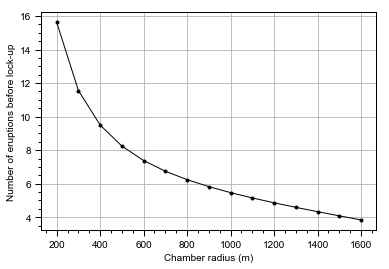

In [50]:
%%time
n = 10
p_gauss = np.random.normal(p_mean, p_3sig/3, n)
logeta_gauss = np.random.normal(logeta_mean, logeta_3sig/3, n)
flux_mean = 10 # kg/s
flux_3sig = 0.5 * flux_mean
flux_gauss = np.random.normal(flux_mean, flux_3sig/3, n)
kappa_gauss = np.random.normal(1e-6, 0.5e-6, n)


Rs = np.linspace(200,1600,15)
NofR = []
for R in Rs:
    Ns = []
    for p in p_gauss:
        for logeta in logeta_gauss:
            for kap in kappa_gauss:
                for flux in flux_gauss:
                    Ns.append(N_from_flux(flux, p, logeta, R=R, rho_mm=2600, kappa=kap))
    #print(np.mean(Ns), np.std(Ns))
    NofR.append(np.mean(Ns))
plt.plot(Rs, NofR, 'k.-')
plt.xlabel('Chamber radius (m)')
plt.ylabel('Number of eruptions before lock-up')
plt.grid()
plt.show()

#### Fig.
Dependence on flux

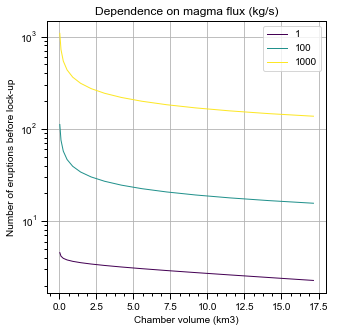

CPU times: user 696 ms, sys: 160 ms, total: 856 ms
Wall time: 549 ms


In [13]:
%%time
n = 10
p_gauss = np.random.normal(p_mean, p_3sig/3, n)
logeta_gauss = np.random.normal(logeta_mean, logeta_3sig/3, n)
flux_mean = 10 # kg/s
flux_3sig = 0.5 * flux_mean
flux_gauss = np.random.normal(flux_mean, flux_3sig/3, n)
kappa_gauss = np.random.normal(1e-6, 0.5e-6, n)


Rs = np.linspace(200,1600,15)
Vols = 4/3*np.pi * Rs**3 * 1e-9
fluxes = [1,100,1000]
clrs = colors(len(fluxes), 'viridis')
plt.figure(figsize=[5,5])

for flux in fluxes:
    NofR = []
    for R in Rs:
        Ns = []
        for p in p_gauss:
            for logeta in logeta_gauss:
                for kap in kappa_gauss:
                    Ns.append(N_from_flux(flux, p, logeta, R=R, rho_mm=2600, kappa=kap))
        NofR.append(np.mean(Ns))
    plt.plot(Vols, NofR, c=next(clrs), label=flux)
    plt.yscale('log')
# plt.plot(Rs, NofR, 'k.-')
plt.title('Dependence on magma flux (kg/s)')
plt.xlabel('Chamber volume (km3)')
plt.ylabel('Number of eruptions before lock-up')
plt.legend()
plt.grid()
plt.show()

#### Fig.
Dependence on flux

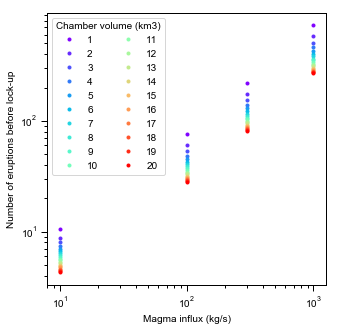

CPU times: user 2.89 s, sys: 132 ms, total: 3.02 s
Wall time: 2.7 s


In [35]:
%%time 
n = 20
p_gauss = np.random.normal(p_mean, p_3sig/3, n)
logeta_gauss = np.random.normal(logeta_mean, logeta_3sig/3, n)
# flux_mean = 10 # kg/s
# flux_3sig = 0.5 * flux_mean
# flux_gauss = np.random.normal(flux_mean, flux_3sig/3, n)
fluxes = [10, 100,300, 1000]
kappa_gauss = np.random.normal(1e-6, 0.5e-6, n)


Rs = np.arange(200,1601,100)
Vs = np.arange(1,21,1)
clrs = colors(len(Vs), 'rainbow')
plt.figure(figsize=[5,5])
for V in Vs:
    R = radius_of_sphere(V) * 1000
    N_of_flux = []
    for flux in fluxes:
        Ns = []
        for p in p_gauss:
            for logeta in logeta_gauss:
                for kap in kappa_gauss:
                    Ns.append(N_from_flux(flux, p, logeta, R=R, rho_mm=2600, kappa=kap))
        N_of_flux.append(np.mean(Ns))
    #label = volume_of_sphere(R) / 1e9
    plt.plot(fluxes, N_of_flux, '.', c=next(clrs), label='%.0f' %V)
plt.xlabel('Magma influx (kg/s)')
plt.ylabel('Number of eruptions before lock-up')
# plt.title('Chamber volume (km3)')
plt.xscale('log')
plt.yscale('log')
# plt.grid()
plt.legend(ncol=2, title='Chamber volume (km3)')
plt.show()

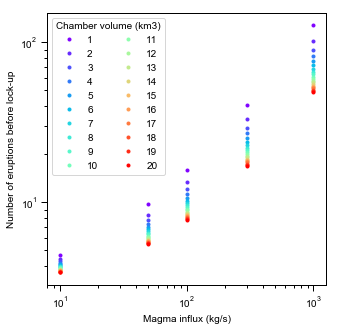

CPU times: user 3.38 s, sys: 140 ms, total: 3.52 s
Wall time: 3.2 s


In [37]:
%%time 
n = 20
p_gauss = np.random.normal(p_mean, p_3sig/3, n)
logeta_gauss = np.random.normal(logeta_mean, logeta_3sig/3, n)
# flux_mean = 10 # kg/s
# flux_3sig = 0.5 * flux_mean
# flux_gauss = np.random.normal(flux_mean, flux_3sig/3, n)
fluxes = [10, 50, 100,300, 1000]
kappa_gauss = np.random.normal(3e-6, 0.5e-6, n)


Rs = np.arange(200,1601,100)
Vs = np.arange(1,21,1)
clrs = colors(len(Vs), 'rainbow')
plt.figure(figsize=[5,5])
for V in Vs:
    R = radius_of_sphere(V) * 1000
    N_of_flux = []
    for flux in fluxes:
        Ns = []
        for p in p_gauss:
            for logeta in logeta_gauss:
                for kap in kappa_gauss:
                    Ns.append(N_from_flux(flux, p, logeta, R=R, rho_mm=2600, kappa=kap))
        N_of_flux.append(np.mean(Ns))
    #label = volume_of_sphere(R) / 1e9
    plt.plot(fluxes, N_of_flux, '.', c=next(clrs), label='%.0f' %V)
plt.xlabel('Magma influx (kg/s)')
plt.ylabel('Number of eruptions before lock-up')
# plt.title('Chamber volume (km3)')
plt.xscale('log')
plt.yscale('log')
# plt.grid()
plt.legend(ncol=2, title='Chamber volume (km3)')
plt.show()

# Dependence on flux

In [4]:
flux = 4 * 1e-3 # km3/yr
flux = flux * 1e9 / (365*24*3600) # m3/s
print('%.4f m3/s' % flux)
flux_mean = 2600 * flux # kg/s
flux_3sig = 0.5 * flux_mean
print('Mass flux (%.2f +/- %.2f) kg/s' % (flux_mean, flux_3sig))

0.1268 m3/s
Mass flux (329.78 +/- 164.89) kg/s


CPU times: user 6.3 s, sys: 31.8 ms, total: 6.33 s
Wall time: 6.37 s


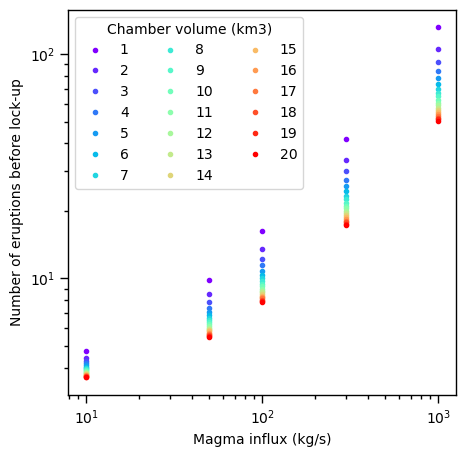

In [23]:
%%time 
n = 20
p_gauss = np.random.normal(p_mean, p_3sig/3, n)
logeta_gauss = np.random.normal(logeta_mean, logeta_3sig/3, n)
# flux_mean = 10 # kg/s
# flux_3sig = 0.5 * flux_mean
# flux_gauss = np.random.normal(flux_mean, flux_3sig/3, n)
fluxes = [10, 50, 100,300, 1000]
kappa_gauss = np.random.normal(3e-6, 0.5e-6, n)


Rs = np.arange(200,1601,100)
Vs = np.arange(1,21,1)
clrs = colors(len(Vs), 'rainbow')
plt.figure(figsize=[5,5])
for V in Vs:
    R = radius_of_sphere(V) * 1000
    N_of_flux = []
    for flux in fluxes:
        Ns = []
        for p in p_gauss:
            for logeta in logeta_gauss:
                for kap in kappa_gauss:
                    Ns.append(N_from_flux(flux, p, logeta, R=R, rho_mm=2600, kappa=kap))
        N_of_flux.append(np.mean(Ns))
    #label = volume_of_sphere(R) / 1e9
    plt.plot(fluxes, N_of_flux, '.', c=next(clrs), label='%.0f' %V)
plt.xlabel('Magma influx (kg/s)')
plt.ylabel('Number of eruptions before lock-up')
# plt.title('Chamber volume (km3)')
plt.xscale('log')
plt.yscale('log')
# plt.grid()
plt.legend(ncol=3, title='Chamber volume (km3)')
# plt.show()
plt.savefig('./figures/konstantinou.pdf', dpi=300)
plt.savefig('./figures/konstantinou.png', dpi=300)

# Radius dependence

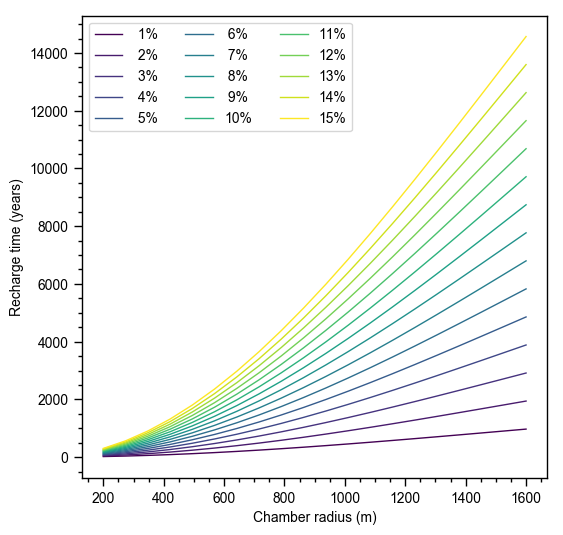

In [58]:
# calc 
N = 5
radii = np.linspace(200, 1600, 20)
rho_mm = 2600 # kg/m3
phis = np.linspace(0.01, 0.15, 15)
clrs = colors(len(phis), cmap='viridis')
# plt.figure(figsize=[4,4])
for phi in phis:
    times = []
    for R in radii:
        mflux = mafic_flux(N=N, p=p_mean,  logeta=logeta_mean, phi=phi_mean, R=R, rho_mm=rho_mm)    
        times.append(t_recharge(mflux, R=R, phi=phi, rho_mm=rho_mm))
    phi *= 100
    plt.plot(radii, times, label='%2.0f%%' % phi, c=next(clrs))
plt.xlabel('Chamber radius (m)')
plt.ylabel('Recharge time (years)')
plt.legend(ncol=3)
R = 300

# print('Recharge time: %2.2f +/- %2.2f years' % (np.mean(times), np.std(times)))

# N dependence

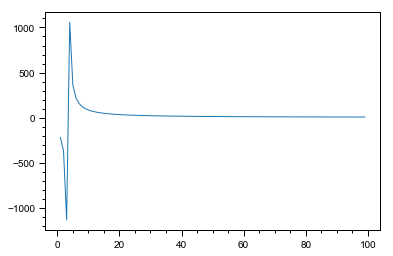

In [10]:
# calc 
Ns = np.arange(1,100)
R = 300
rho_mm = 2600 # kg/m3
clrs = colors(len(Ns), cmap='viridis')
# plt.figure(figsize=[4,4])
times = []
for N in Ns:
    mflux = mafic_flux(N=N, p=p_mean,  logeta=logeta_mean, phi=phi_mean, R=R, rho_mm=rho_mm)    
    times.append(t_recharge(mflux, R=R, phi=phi_mean, rho_mm=rho_mm))
plt.plot(Ns, times)
# plt.xlabel('Chamber radius (m)')
# plt.ylabel('Recharge time (years)')
# plt.legend(ncol=3)
# print('Recharge time: %2.2f +/- %2.2f years' % (np.mean(times), np.std(times)))

# Effect of overpressure

In [31]:
# calc 
N = 5
R = 300 # m
rho_mm = 2600 # kg/m3

n = 10000
p_gauss = np.random.normal(p_mean, p_3sig/3, n)
times = []
for p in p_gauss:
    mflux = mafic_flux(N=N, p=p,  logeta=logeta_mean, phi=phi_mean, R=R, rho_mm=rho_mm)    
    times.append(t_recharge(mflux, R=R, phi=phi_mean, rho_mm=rho_mm))

print('Recharge time: %2.2f +/- %2.2f years' % (np.mean(times), np.std(times)))

Recharge time: 361.01 +/- 0.85 years


# Effect of crust viscosity

In [34]:
# calc 
N = 5
R = 300 # m
rho_mm = 2600 # kg/m3

n = 10000
logeta_gauss = np.random.normal(logeta_mean, logeta_3sig/3, n)
times = []
for logeta in logeta_gauss:
    mflux = mafic_flux(N=N, p=p_mean,  logeta=logeta, phi=phi_mean, R=R, rho_mm=rho_mm)    
    times.append(t_recharge(mflux, R=R, phi=phi_mean, rho_mm=rho_mm))

print('Recharge time: %2.2f +/- %2.2f years' % (np.mean(times), np.std(times)))

Recharge time: 357.46 +/- 10.92 years


# Effect of mafic %vol 

In [36]:
# calc 
N = 5
R = 300 # m
rho_mm = 2600 # kg/m3

n = 10000
phi_gauss = np.random.normal(phi_mean, phi_3sig/3, n)
times = []
for phi in phi_gauss:
    mflux = mafic_flux(N=N, p=p_mean,  logeta=logeta_mean, phi=phi, R=R, rho_mm=rho_mm)    
    times.append(t_recharge(mflux, R=R, phi=phi, rho_mm=rho_mm))

print('Recharge time: %2.2f +/- %2.2f years' % (np.mean(times), np.std(times)))

Recharge time: 360.27 +/- 104.55 years


# All effects combined

All effects combined. For n=1000:

Recharge time: 355.17 +/- 108.07 years

Wall time: 55min 50s

In [42]:
%%time 
N = 5
R = 300 # m
rho_mm = 2600 # kg/m3

n = 1000
p_gauss = np.random.normal(p_mean, p_3sig/3, n)
logeta_gauss = np.random.normal(logeta_mean, logeta_3sig/3, n)
phi_gauss = np.random.normal(phi_mean, phi_3sig/3, n)
times = []
for p in p_gauss:
    for logeta in logeta_gauss:
        for phi in phi_gauss:
            mflux = mafic_flux(N=N, p=p,  logeta=logeta, phi=phi, R=R, rho_mm=rho_mm)    
            times.append(t_recharge(mflux, R=R, phi=phi, rho_mm=rho_mm))

print('Recharge time: %2.2f +/- %2.2f years' % (np.mean(times), np.std(times)))

Recharge time: 355.17 +/- 108.07 years
CPU times: user 47min 16s, sys: 2min 3s, total: 49min 19s
Wall time: 55min 50s


# Eruption triggering regimes

In [93]:
def t_inj(rho_mm, R, mflux):
    return (4/3)*np.pi*R**3 / mflux
def t_cool(kappa, R):
    return R**2 / kappa
def t_relax(logeta, p):
    eta = 10**logeta
    return eta / p
def theta1(t_cool, t_inj):
    return t_cool / t_inj
def theta2(t_relax, t_inj):
    return t_relax / t_inj

In [118]:
R = 300
t_cool(2*kappa, R) / t_inj(rho_mm=2600, R=R, mflux=.01)

3.978873577297384

113097335.52923255

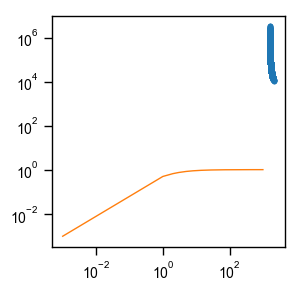

In [121]:
N = 5
R = 300 # m
kappa = 1e-6 # m2/s
rho_mm = 2600 # kg/m3
n = 100
p_gauss = np.random.normal(p_mean, p_3sig/3, n)
logeta_gauss = np.random.normal(logeta_mean, logeta_3sig/3, n)
thetas1, thetas2 = [], []
for p in p_gauss:
    for logeta in logeta_gauss:
        mflux = mafic_flux(N=N, p=p,  logeta=logeta, phi=None, R=R, rho_mm=rho_mm)
        ti = t_inj(rho_mm, R, mflux)
        tc = t_cool(kappa, R)
        tr = t_relax(logeta, p)
        thetas1.append(tc/ti)
        thetas2.append(tr/ti)
figure(3,3)
plt.loglog(thetas1, thetas2, '.')
th1 = np.linspace(1e-3,1e3,1000)
b1=2.4
b2=3.5
b3=2.5
th2 = b3 * th1 / (b1 * th1 + b2 -1)
plt.loglog(th1,th2)
# plt.xlim(1e-3,1e3)        
# plt.ylim(1e-2,1e2)        
plt.show()

In [108]:
p

21780410.73173735

# ...